# Creating Customer Segments
## Unsupervised Learning

A wholesale distributor recently tested a change to their delivery method for some customers, by moving from a morning delivery service five days a week to a cheaper evening delivery service three days a week. Initial testing did not discover any significant unsatisfactory results, so they implemented the cheaper option for all customers. Almost immediately, the distributor began getting complaints about the delivery service change and customers were canceling deliveries — losing the distributor more money than what was being saved. We've been hired by the wholesale distributor to find what types of customers they have to help them make better, more informed business decisions in the future. The task is to use unsupervised learning techniques to see if any similarities exist between customers, and how to best segment customers into distinct categories.

## Getting Started

In this project, we will analyze a dataset containing data on various customers' annual spending amounts (reported in *monetary units*) of diverse product categories for internal structure. One goal of this project is to best describe the variation in the different types of customers that a wholesale distributor interacts with. Doing so would equip the distributor with insight into how to best structure their delivery service to meet the needs of each customer.

The dataset for this project can be found on the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Wholesale+customers). For the purposes of this project, the features `'Channel'` and `'Region'` will be excluded in the analysis — with focus instead on the six product categories recorded for customers.

First lets initialize our libraries and load the data into a pandas dataframe.

In [30]:
# Import libraries necessary for this project
import numpy as np
import pandas as pd
import renders as rs
from IPython.display import display # Allows the use of display() for DataFrames

import matplotlib.pyplot as plt
import seaborn as sns
# Pretty display for notebooks
%matplotlib inline
# plt.style.use('ggplot')

# Load the wholesale customers dataset
try:
    data = pd.read_csv("customers.csv")
    data.drop(['Region', 'Channel'], axis = 1, inplace = True)
    print "Wholesale customers dataset has {} samples with {} features each.".format(*data.shape)
except:
    print "Dataset could not be loaded. Is the dataset missing?"
    
# Set a random state for the training algorithms
RAN_STATE = 29

#Set size for figures
FIG_SIZE = (14,8)

Wholesale customers dataset has 440 samples with 6 features each.


# Data Exploration
In this section, we will begin exploring the data through visualizations and code to understand how each feature is related to the others.

In [31]:
# Display a description of the dataset
display(data.describe())
print("Number of missing values", data.isnull().sum().sum())

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
count,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000
mean,12000.297727,5796.265909,7951.277273,3071.931818,2881.493182,1524.870455
std,12647.328865,7380.377175,9503.162829,4854.673333,4767.854448,2820.105937
min,3.000000,55.000000,3.000000,25.000000,3.000000,3.000000
25%,3127.750000,1533.000000,2153.000000,742.250000,256.750000,408.250000
50%,8504.000000,3627.000000,4755.500000,1526.000000,816.500000,965.500000
75%,16933.750000,7190.250000,10655.750000,3554.250000,3922.000000,1820.250000
max,112151.000000,73498.000000,92780.000000,60869.000000,40827.000000,47943.000000


('Number of missing values', 0)


This can be can also be visualized using a box plot.

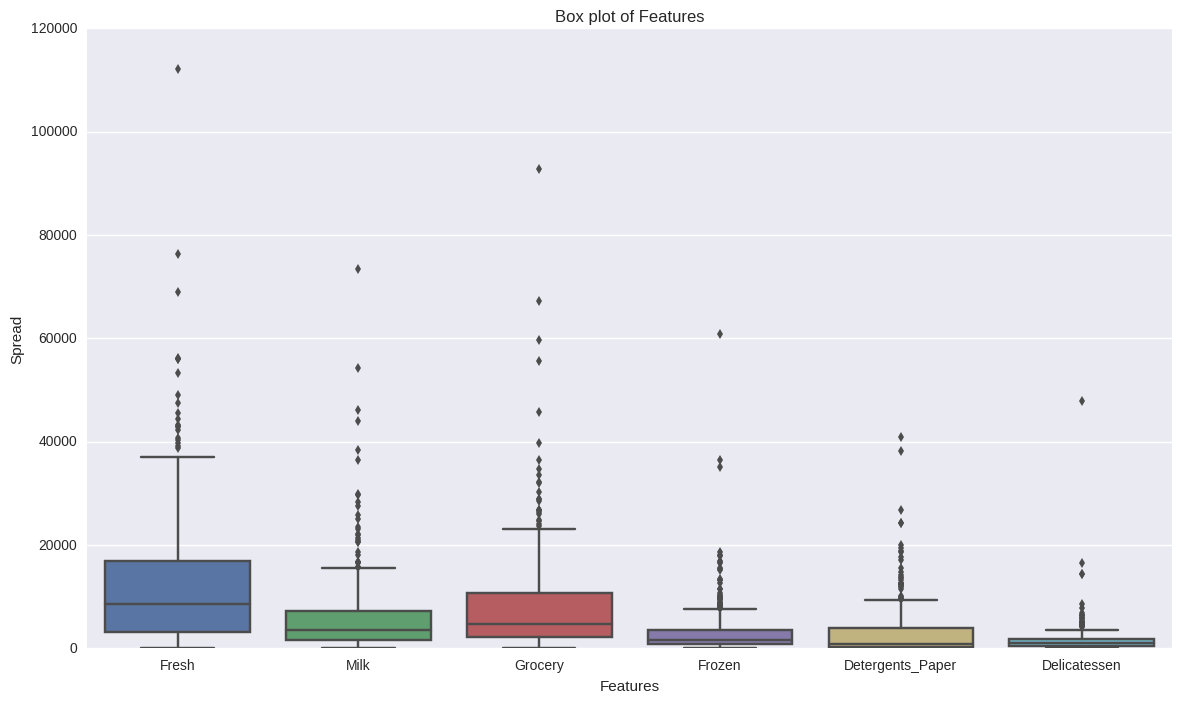

In [32]:
### Box Plot
plt.figure(figsize=FIG_SIZE)
plt.title('Box plot of Features')
plt.ylabel('Spread')
plt.xlabel('Features')
display(sns.boxplot(data[data.columns]))

Interesting. It seems that the data has a significant amount of outliers.

## Implementation: Selecting Samples
To get a better understanding of the customers and how their data will transform through the analysis, it would be best to select a few sample data points and explore them in more detail.

In [5]:
#printing out the index of the max of each catagory.
print data.idxmax(axis=0, skipna=True)

Fresh               181
Milk                 86
Grocery              85
Frozen              325
Detergents_Paper     85
Delicatessen        183
dtype: int64


In [6]:
# We will select the following indicies as points of interest.
indices = [181,325,86]

# Create a DataFrame of the chosen samples
samples = pd.DataFrame(data.loc[indices], columns = data.columns)#.reset_index(drop = True)
print "Chosen samples of wholesale customers dataset:"
display(samples)

Chosen samples of wholesale customers dataset:


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
181,112151,29627,18148,16745,4948,8550
325,32717,16784,13626,60869,1272,5609
86,22925,73498,32114,987,20070,903


We can visualize a percentage representation of these customers spending in each catagory using the following heatmap.

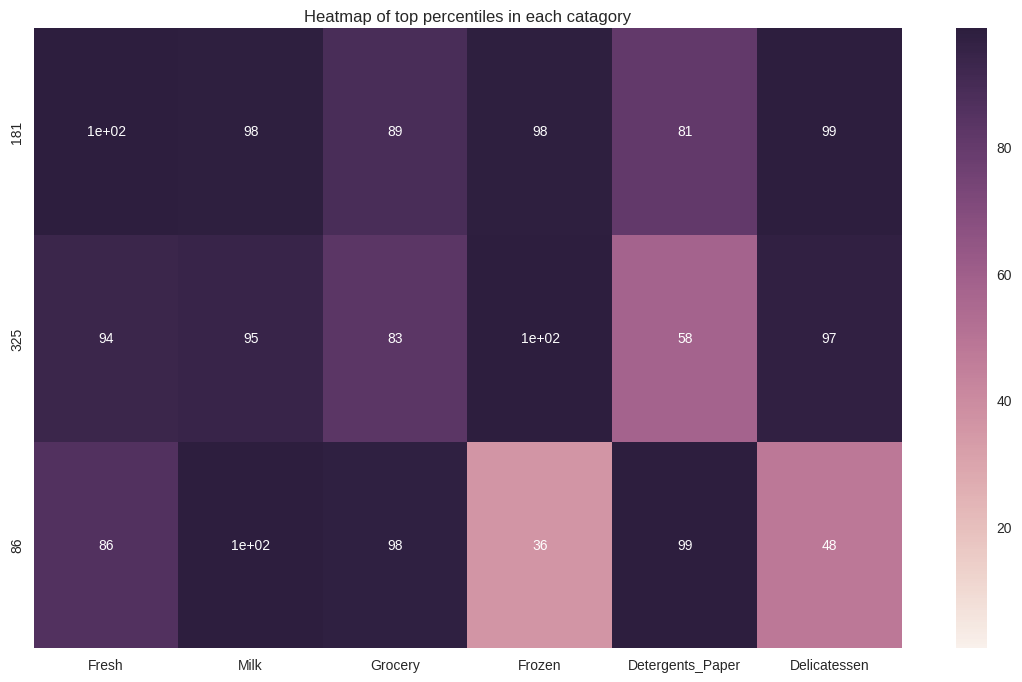

In [7]:
# First, calculate the percentile ranks of the whole dataset.
percentiles = data.rank(pct=True)
# Then, round it up, and multiply by 100
percentiles = 100*percentiles.round(decimals=3)
# Select the indices you chose from the percentiles dataframe
percentiles = percentiles.iloc[indices]
# Now, create the heat map using the seaborn library
plt.figure(figsize = FIG_SIZE)
plt.title("Heatmap of top percentiles in each catagory")
_ = sns.heatmap(percentiles, vmin=1, vmax=99, annot=True)

Considering the total purchase cost of each product category and the statistical description of the dataset above for the sample customers, the following observations are made:

* __Customer 181__: Customer 181 has the largest 'Fresh' value out of the dataset. It is roughly 9 standard deviations above the mean of the dataset. Its values for all of the other categories are also quite a bit higher than the mean. Since the numbers are high across the board, I would assume that this customer is a small market or convenience store that sells all categories of goods.
* __Customer 325__: This customer has a value larger than the mean in every category except 'Detergents_Paper' and the largest in the "Frozen" category. As the 'Detergents_Paper' category is lower than the mean by .25% of a standard deviation, it can still be considered a fairly average number. This makes sense, as frozen meals don't normally require a lot of cleanup. If I were to take a guess I would assume this customer provides low-cost meals to needy people.
* __Customer 86__: This customer has the largest "Milk" expense in the dataset. It is larger in the "Grocery", "Fresh" and "Detergent_Paper" categories than the mean, and smaller in the "Frozen" and "Delicatessen". This could be a cafe, as coffee needs a lot of milk, cleaning standards should be strict, and it would also sell some snacks for it's customers.  It wouldn't be expected to have a lot of frozen food.


## Implementation: Feature Relevance
One interesting thought to consider is if one (or more) of the six product categories is actually relevant for understanding customer purchasing. That is to say, is it possible to determine whether customers purchasing some amount of one category of products will necessarily purchase some proportional amount of another category of products? We can make this determination quite easily by training a supervised regression learner on a subset of the data with one feature removed, and then score how well that model can predict the removed feature.

In [8]:
from sklearn.model_selection import train_test_split
from sklearn import tree
# Make a copy of the DataFrame, using the 'drop' function to drop the given feature
new_data = data.copy()
new_data.drop('Detergents_Paper', axis = 1, inplace = True)

# Split the data into training and testing sets using the given feature as the target
X_train, X_test, y_train, y_test = train_test_split(new_data, 
                                                    data['Detergents_Paper'], 
                                                    test_size =.25,
                                                    random_state = RAN_STATE)

regressor = tree.DecisionTreeRegressor(random_state=RAN_STATE)
regressor.fit(X_train, y_train)

# Report the score of the prediction using the testing set
score = regressor.score(X_test, y_test)
print("R^2 score is ", score)

('R^2 score is ', 0.77502271478108398)


The feature that I attempted to predict was the Detergent_Paper feature. It returned a score of .775, meaning that the values of this category can be predicted by the other features in the dataset and is, therefore, redundant to some extent.

## Visualize Feature Distributions
To get a better understanding of the dataset, we can construct a scatter matrix of each of the six product features present in the data.

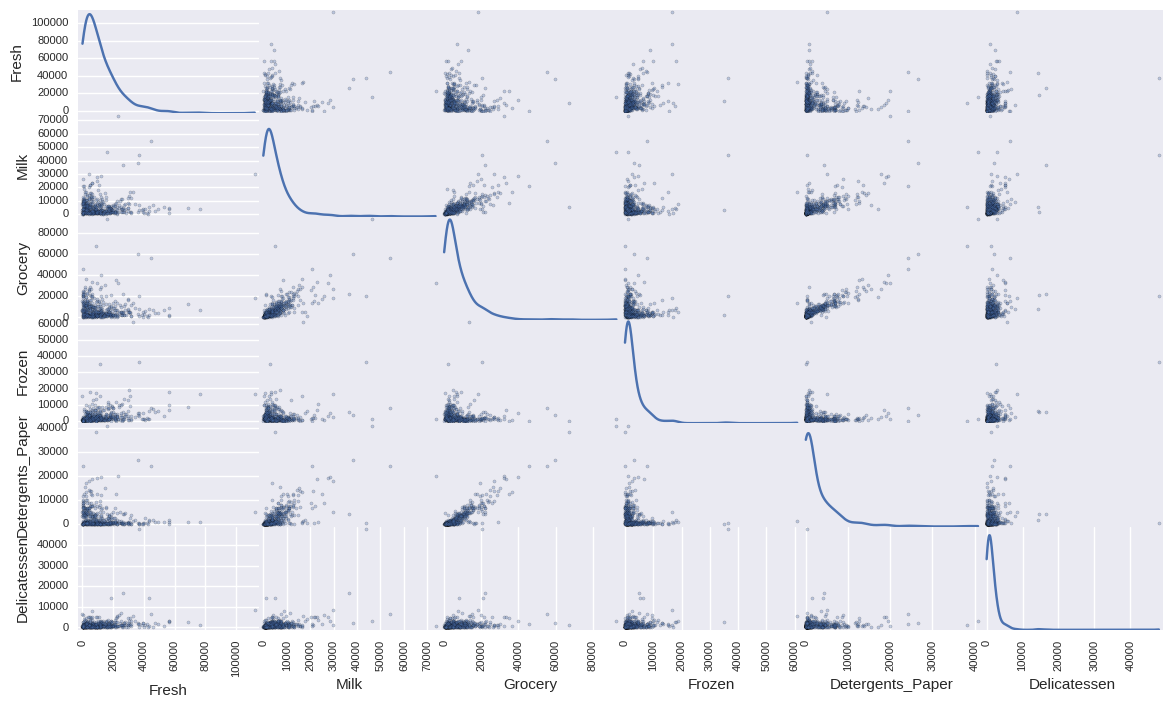

In [9]:
# Produce a scatter matrix for each pair of features in the data
pd.scatter_matrix(data, alpha = 0.3, figsize = FIG_SIZE, diagonal = 'kde');

From the scatterplot, we can see our original hypothesis was correct. There is correlation between 'Detergent_Paper' and milk and groceries.

We can also comment on the distribution of the data. It seems to be left skewed in all instances. Since the clustering algorithms discussed in this project work under the assumption that the data features are (roughly) normally distributed. Significant deviation from zero skewness indicates that we must apply some kind of normalisation to make the features normally distributed.

Notably, there seems to be no significant correlation between 'Delicatessen' and any other catagory. Lets repeat the experiment using 'Delicatessen' as the label.

In [10]:
new_data = data.copy()
new_data.drop('Delicatessen', axis = 1, inplace = True)

# Split the data into training and testing sets using the given feature as the target
X_train, X_test, y_train, y_test = train_test_split(new_data, 
                                                    data['Delicatessen'], 
                                                    test_size =.25,
                                                    random_state = RAN_STATE)

regressor = tree.DecisionTreeRegressor(random_state = RAN_STATE)
regressor.fit(X_train, y_train)

# Report the score of the prediction using the testing set
score = regressor.score(X_test, y_test)
print("R^2 score is ", score)

('R^2 score is ', 0.39305937492344423)


The final score for a Delicatessen is 0.393. Agreeing strongly with our hypothesis that 'Delicatessen' cannot easily be predicted by the other data, meaning it has no strong correlation to the other data, and is therefore not redundant.

We can get a good sense of how all the features correlate to each other using another heat map.

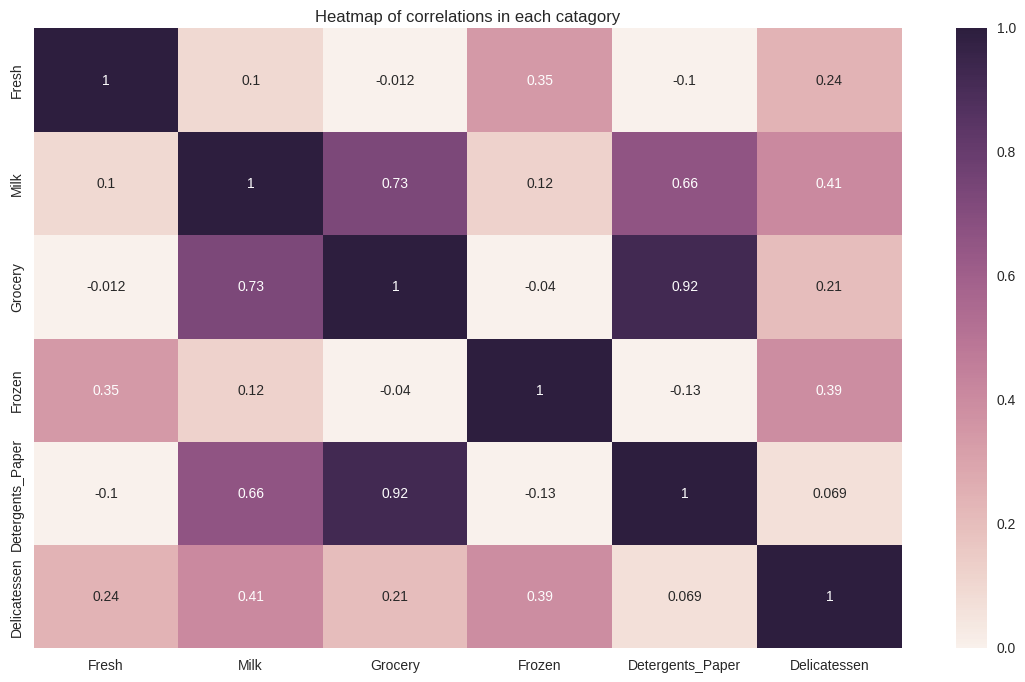

In [11]:
correlations = data.corr()
plt.figure(figsize = FIG_SIZE)
plt.title("Heatmap of correlations in each catagory")
_ = sns.heatmap(correlations, vmin=0, vmax=1, annot=True)

# Data Preprocessing
In this section, we will preprocess the data to create a better representation of customers by performing a scaling on the data and detecting (and optionally removing) outliers. 


## Implementation: Feature Scaling
If data is not normally distributed, especially if the mean and median vary significantly (indicating a large skew), it is most [often appropriate](http://econbrowser.com/archives/2014/02/use-of-logarithms-in-economics) to apply a non-linear scaling — particularly for financial data. One way to achieve this scaling is by using a [Box-Cox test](http://scipy.github.io/devdocs/generated/scipy.stats.boxcox.html), which calculates the best power transformation of the data that reduces skewness. A simpler approach which can work in most cases would be applying the natural logarithm.

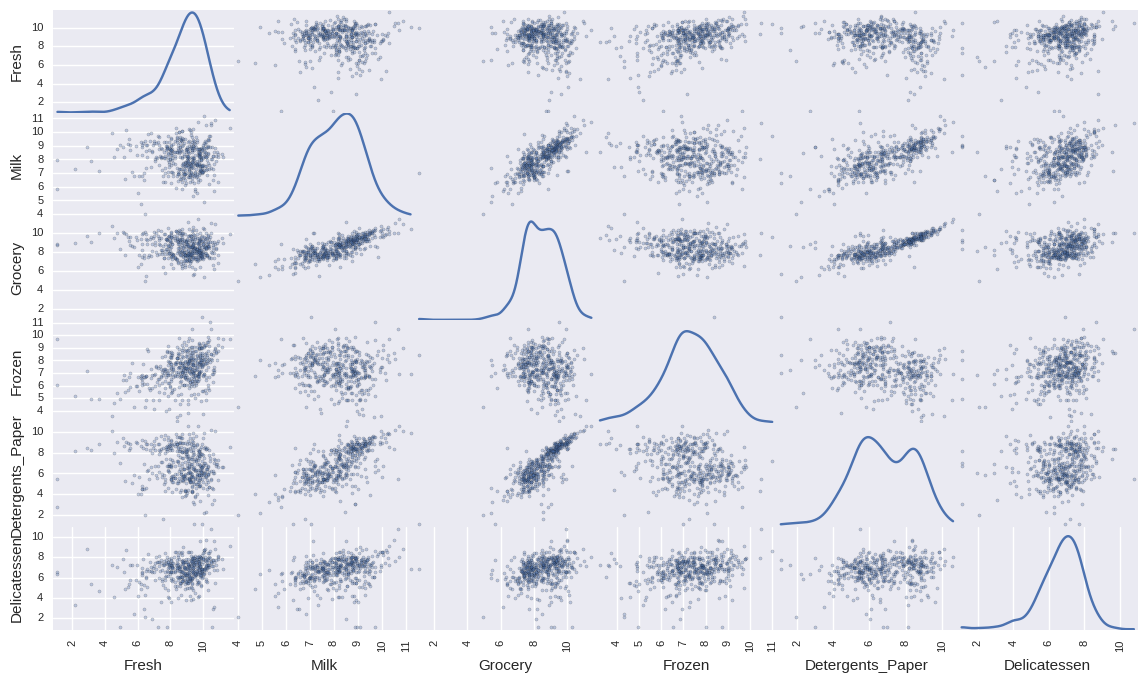

In [12]:
# Scale the data using the natural logarithm
log_data = np.log(data)

# Scale the sample data using the natural logarithm
log_samples = np.log(samples)

# Produce a scatter matrix for each pair of newly-transformed features
pd.scatter_matrix(log_data, alpha = 0.3, figsize = FIG_SIZE, diagonal = 'kde');

## Observation
After applying a natural logarithm scaling to the data, the distribution of each feature is much more normal. The correlations noted above between 'Milk', 'Groceries', and 'Detergents_Paper' still exist. Notably, 'Detergents_Paper' seems to have a bimodal distribution.

The code below shows how the data has changed after having the natural logarithm applied to it.

In [13]:
# Display the log-transformed sample data
print 'log_data samples:'
display(log_samples)
print 'log_data statistics:'
display(log_data.describe())

log_data samples:


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
181,11.627601,10.296441,9.806316,9.725855,8.506739,9.053687
325,10.395650,9.728181,9.519735,11.016479,7.148346,8.632128
86,10.039983,11.205013,10.377047,6.894670,9.906981,6.805723


log_data statistics:


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
count,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000
mean,8.730544,8.121047,8.441169,7.301396,6.785972,6.665133
std,1.480071,1.081365,1.116172,1.284540,1.721020,1.310832
min,1.098612,4.007333,1.098612,3.218876,1.098612,1.098612
25%,8.048059,7.334981,7.674616,6.609678,5.548101,6.011875
50%,9.048286,8.196159,8.467057,7.330388,6.705018,6.872645
75%,9.737064,8.880480,9.273854,8.175896,8.274341,7.506728
max,11.627601,11.205013,11.437986,11.016479,10.617099,10.777768


### Implementation: Outlier Detection
Detecting outliers in the data is extremely important in the data preprocessing step of any analysis. The presence of outliers can often skew results which take into consideration these data points. There are many "rules of thumb" for what constitutes an outlier in a dataset. Here, we will use [Tukey's Method for identfying outliers](http://datapigtechnologies.com/blog/index.php/highlighting-outliers-in-your-data-with-the-tukey-method/): An *outlier step* is calculated as 1.5 times the interquartile range (IQR). A data point with a feature that is beyond an outlier step outside of the IQR for that feature is considered abnormal.

In [14]:
all_outliers = []
# For each feature find the data points with extreme high or low values
for feature in log_data.keys():
    
    # Calculate Q1 (25th percentile of the data) for the given feature
    Q1 = np.percentile(log_data[feature], 25)
    
    # Calculate Q3 (75th percentile of the data) for the given feature
    Q3 = np.percentile(log_data[feature], 75)
    
    # Use the interquartile range to calculate an outlier step (1.5 times the interquartile range)
    step = (Q3 - Q1) * 1.5
    
    # Display the outliers
    print "Data points considered outliers for the feature '{}':".format(feature)
    outlier_points = log_data[~((log_data[feature] >= Q1 - step) & (log_data[feature] <= Q3 + step))]
    display(outlier_points)
    
    for index in outlier_points.index.values:
        all_outliers.append(index)


#Find which data points are outliers on two or more features.
all_outliers, indices = np.unique(all_outliers, return_inverse=True)
counts = np.bincount(indices)
outliers_2_or_more = all_outliers[counts>1]
print 'Outliers on two or more features:', outliers_2_or_more    

# Select the indices for data points you wish to remove
outliers  = outliers_2_or_more

# Remove the outliers, if any were specified
good_data = log_data.drop(log_data.index[outliers]).reset_index(drop = True)

Data points considered outliers for the feature 'Fresh':


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
65,4.442651,9.950323,10.732651,3.583519,10.095388,7.260523
66,2.197225,7.335634,8.911530,5.164786,8.151333,3.295837
81,5.389072,9.163249,9.575192,5.645447,8.964184,5.049856
95,1.098612,7.979339,8.740657,6.086775,5.407172,6.563856
96,3.135494,7.869402,9.001839,4.976734,8.262043,5.379897
128,4.941642,9.087834,8.248791,4.955827,6.967909,1.098612
171,5.298317,10.160530,9.894245,6.478510,9.079434,8.740337
193,5.192957,8.156223,9.917982,6.865891,8.633731,6.501290
218,2.890372,8.923191,9.629380,7.158514,8.475746,8.759669
304,5.081404,8.917311,10.117510,6.424869,9.374413,7.787382


Data points considered outliers for the feature 'Milk':


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
86,10.039983,11.205013,10.377047,6.894670,9.906981,6.805723
98,6.220590,4.718499,6.656727,6.796824,4.025352,4.882802
154,6.432940,4.007333,4.919981,4.317488,1.945910,2.079442
356,10.029503,4.897840,5.384495,8.057377,2.197225,6.306275


Data points considered outliers for the feature 'Grocery':


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
75,9.923192,7.036148,1.098612,8.390949,1.098612,6.882437
154,6.432940,4.007333,4.919981,4.317488,1.945910,2.079442


Data points considered outliers for the feature 'Frozen':


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
38,8.431853,9.663261,9.723703,3.496508,8.847360,6.070738
57,8.597297,9.203618,9.257892,3.637586,8.932213,7.156177
65,4.442651,9.950323,10.732651,3.583519,10.095388,7.260523
145,10.000569,9.034080,10.457143,3.737670,9.440738,8.396155
175,7.759187,8.967632,9.382106,3.951244,8.341887,7.436617
264,6.978214,9.177714,9.645041,4.110874,8.696176,7.142827
325,10.395650,9.728181,9.519735,11.016479,7.148346,8.632128
420,8.402007,8.569026,9.490015,3.218876,8.827321,7.239215
429,9.060331,7.467371,8.183118,3.850148,4.430817,7.824446
439,7.932721,7.437206,7.828038,4.174387,6.167516,3.951244


Data points considered outliers for the feature 'Detergents_Paper':


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
75,9.923192,7.036148,1.098612,8.390949,1.098612,6.882437
161,9.428190,6.291569,5.645447,6.995766,1.098612,7.711101


Data points considered outliers for the feature 'Delicatessen':


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
66,2.197225,7.335634,8.911530,5.164786,8.151333,3.295837
109,7.248504,9.724899,10.274568,6.511745,6.728629,1.098612
128,4.941642,9.087834,8.248791,4.955827,6.967909,1.098612
137,8.034955,8.997147,9.021840,6.493754,6.580639,3.583519
142,10.519646,8.875147,9.018332,8.004700,2.995732,1.098612
154,6.432940,4.007333,4.919981,4.317488,1.945910,2.079442
183,10.514529,10.690808,9.911952,10.505999,5.476464,10.777768
184,5.789960,6.822197,8.457443,4.304065,5.811141,2.397895
187,7.798933,8.987447,9.192075,8.743372,8.148735,1.098612
203,6.368187,6.529419,7.703459,6.150603,6.860664,2.890372


Outliers on two or more features: [ 65  66  75 128 154]


The datapoints that appear as outliers in more than one feature have been removed from the dataset. Since they are so few and far between, they will not be helpful in forming clusters of customer types. 

# Feature Transformation
In this section we will use principal component analysis (PCA) to draw conclusions about the underlying structure of the wholesale customer data. Since using PCA on a dataset calculates the dimensions which best maximize variance, we will find which compound combinations of features best describe customers.

# Implementation: PCA

Now that the data has been scaled to a more normal distribution and has had any necessary outliers removed, we can now apply PCA to the `good_data` to discover which dimensions about the data best maximize the variance of features involved. In addition to finding these dimensions, PCA will also report the *explained variance ratio* of each dimension — how much variance within the data is explained by that dimension alone. Note that a component (dimension) from PCA can be considered a new "feature" of the space, however it is a composition of the original features present in the data.

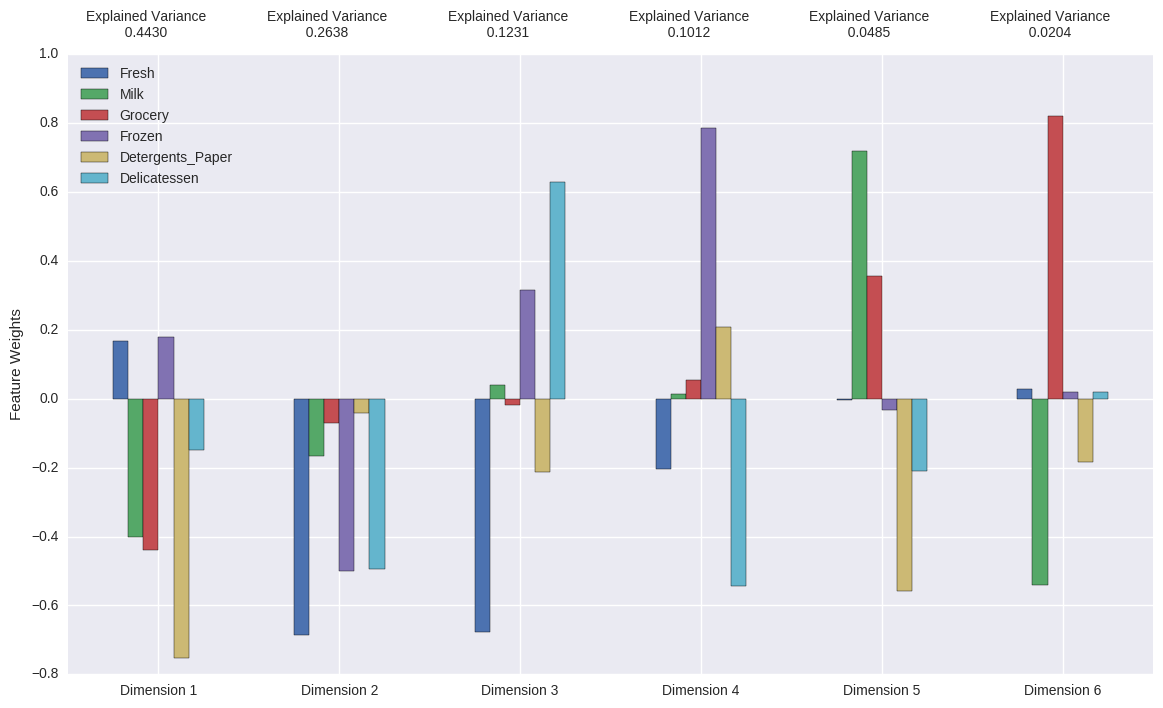

In [15]:
from sklearn.decomposition import PCA
# Apply PCA to the good data with the same number of dimensions as features
pca = PCA(n_components=6).fit(good_data)

# Apply a PCA transformation to the sample log-data
pca_samples = pca.transform(log_samples)

# Generate PCA results plot
pca_results = rs.pca_results(good_data, pca)


In [16]:
print pca_results['Explained Variance']
print '\nCumulative sum:\n',pca_results['Explained Variance'].cumsum()

Dimension 1    0.4430
Dimension 2    0.2638
Dimension 3    0.1231
Dimension 4    0.1012
Dimension 5    0.0485
Dimension 6    0.0204
Name: Explained Variance, dtype: float64

Cumulative sum:
Dimension 1    0.4430
Dimension 2    0.7068
Dimension 3    0.8299
Dimension 4    0.9311
Dimension 5    0.9796
Dimension 6    1.0000
Name: Explained Variance, dtype: float64


The first principle component, can explain 44.3% of the varience in the data. The second principle component can explain 26.38%. Their cumulative sum can explain 70.68% of the variance of the data. The first four components can cumulatively explain 93.11% of the variance in the data.

In terms of customer spending, the first four dimensions could represent:
* __Dimension 1__: The first dimension shows a strong correlation with 'Milk', 'Grocery' and 'Detergent_Paper' catagories, in agreement with out previous scatterplot analysis. These catagories are all items sold in retail. Therefore, a customer like a market would have a high value along this dimension.
* __Dimension 2__:  The second dimension shows a strong correlation with 'Fresh', 'Frozen', and 'Delicatessen' and could be considered orthogonal to Dimension 1. These catagories are all items used in cuisine, therefore a customer like a restaurant would have a high value along this dimension
* __Dimension 3__: The third dimension represents high spending in the 'Frozen', and 'Delicatessen' catagories, with low spending in the 'Fresh' catagory. This direction reflects low cost meals, therefore a customer like a homeless shelter would have a high value along this dimension.
* __Dimension 4__: The forth dimension represents high 'Frozen' spending vs. low 'Delicatessen' and 'Fresh' spending or vice versa. This direction could reflects a snackery, that doesn't output a high volume of food.


Let's see how this transformation affected our sample points

In [17]:
# Display sample log-data after having a PCA transformation applied
display(pd.DataFrame(np.round(pca_samples, 4), columns = pca_results.index.values))

,Dimension 1,Dimension 2,Dimension 3,Dimension 4,Dimension 5,Dimension 6
0,-2.1899,-4.8605,0.0008,0.4827,0.5041,-0.1988
1,-0.7286,-4.2802,1.2473,1.6688,0.8004,0.1030
2,-4.2903,-1.4952,-1.4997,0.1394,1.1469,-0.6255


## Implementation: Dimensionality Reduction
When using principal component analysis, one of the main goals is to reduce the dimensionality of the data — in effect, reducing the complexity of the problem. Dimensionality reduction comes at a cost: Fewer dimensions used implies less of the total variance in the data is being explained. Because of this, the *cumulative explained variance ratio* is extremely important for knowing how many dimensions are necessary for the problem. Additionally, if a signifiant amount of variance is explained by only two or three dimensions, the reduced data can be visualized afterwards.

Lets try fitting our six dimensional data to two dimensions, so it will be easy to visualize.

In [18]:
# Apply PCA by fitting the good data with only two dimensions
pca = PCA(n_components=2).fit(good_data)

# Transform the good data using the PCA fit above
reduced_data = pca.transform(good_data)

# Transform the sample log-data using the PCA fit above
pca_samples = pca.transform(log_samples)

# Create a DataFrame for the reduced data
reduced_data = pd.DataFrame(reduced_data, columns = ['Dimension 1', 'Dimension 2'])

We can now visualize this dimensionality reduction and determine the cumulative sum of the explained variance.

Exaplained variance for each dimension
Dimension 1    0.4430
Dimension 2    0.2638
Name: Explained Variance, dtype: float64

Cumulative sum:
Dimension 1    0.4430
Dimension 2    0.7068
Name: Explained Variance, dtype: float64


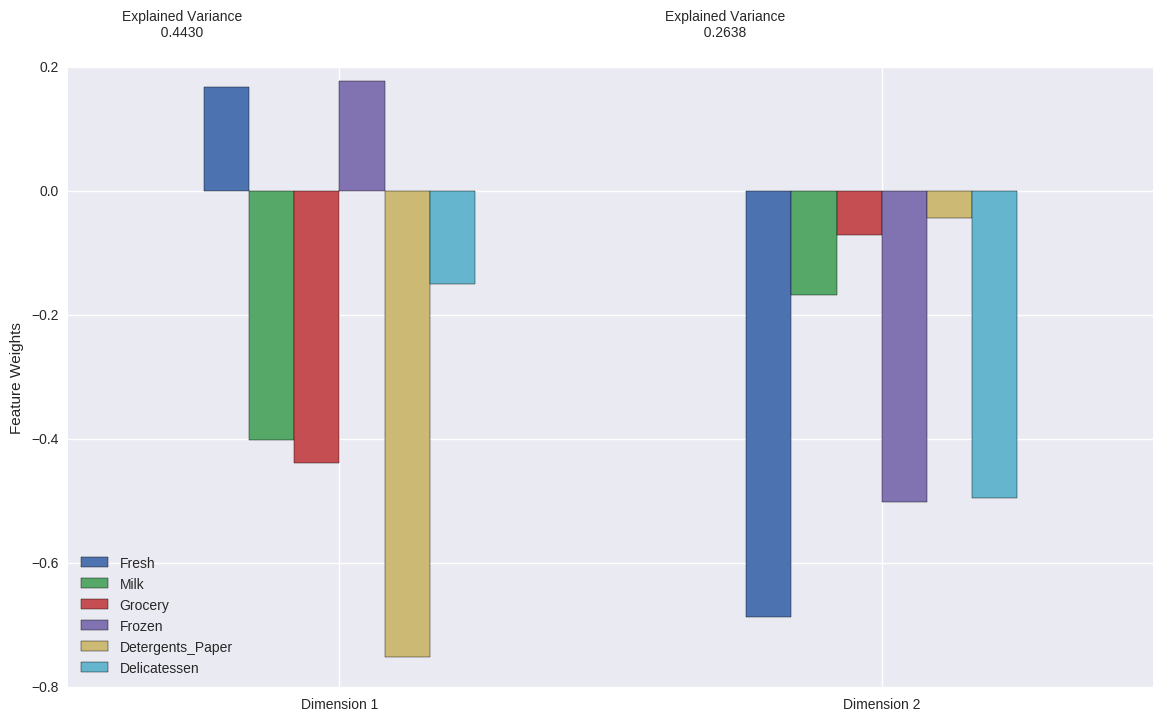

In [19]:
# Generate PCA results plot
pca_results_reduced = rs.pca_results(good_data, pca)
print 'Exaplained variance for each dimension\n',pca_results_reduced['Explained Variance']
print '\nCumulative sum:\n',pca_results_reduced['Explained Variance'].cumsum()

 The cumulative sum of the explained varience for the two dimensions is 70.68%: not a great score. Often, there is a tradeoff between the need to reduce dimensionality of the data (for training purposes), and accuracy of the model. Nevertheless, we will proceed with the analysis using two pricipal directions as this is easier to visualize. If this were a more serious analysis, I would use 4 pricipal directions, as this would explain 93.11% of the varience in the data.

## Observation
Lets see how this transformation affected our sample points.

In [20]:
# Display sample log-data after applying PCA transformation in two dimensions
display(pd.DataFrame(np.round(pca_samples, 4), columns = ['Dimension 1', 'Dimension 2']))

,Dimension 1,Dimension 2
0,-2.1899,-4.8605
1,-0.7286,-4.2802
2,-4.2903,-1.4952


# Clustering

A K-Means clustering algorithm allows you to classify the data points as being 100% belonging to one cluster and is siginificatly faster than GMM as discussed [here](https://www.quora.com/What-is-the-difference-between-K-means-and-the-mixture-model-of-Gaussian). The Gaussian Mixture Model (GMM), or "Soft Clustering" assumes that each data point is a percentage mixture of each of the clusters. For example, this allows for points that are exactly in the middle of two clusters to be classified as 50% one category and 50% the other category.

In the context of this problem, I will use Gaussian Mixture clustering. The goal of the project is to best describe the variation in the different types of customers that a wholesale distributer interacts with, the goal being to design a delivery service to meet the needs of each customer. If a K-Means clustering algorithm is used, it might portray a false sense that there are hard definitive categories. The wholesaler might design their delivery service to cater to one type of defined customer, when in reality the customers have a more multi-dimensional need. A GMM does not make this assumption, unless it is truly portrayed by the data. 

For large datasets, an alternative strategy would be to go with the faster KMeans for preliminary analysis, and later, if the results could be significantly improved, use GMM in the next step while using the cluster assignments and centres obtained from KMeans as the initialisation for GMM. 



## Implementation: Creating Clusters
Depending on the problem, the number of clusters that you expect to be in the data may already be known. When the number of clusters is not known *a priori*, there is no guarantee that a given number of clusters best segments the data, since it is unclear what structure exists in the data — if any. However, we can quantify the "goodness" of a clustering by calculating each data point's *silhouette coefficient*. The [silhouette coefficient](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html) for a data point measures how similar it is to its assigned cluster from -1 (dissimilar) to 1 (similar). Calculating the *mean* silhouette coefficient provides for a simple scoring method of a given clustering.


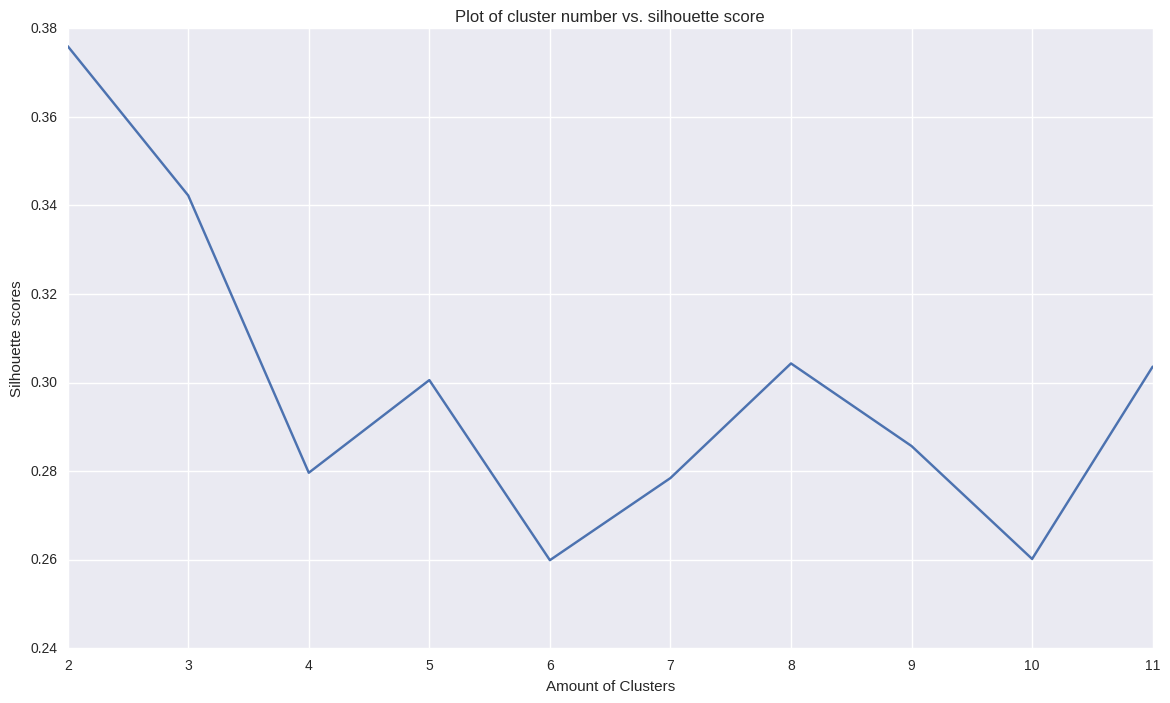

Optimum score: 0.3760


In [21]:
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score

def score_GMM(n_clusters):
    # Apply your clustering algorithm of choice to the reduced data 
    clusterer = GaussianMixture(n_components=n_clusters, random_state = RAN_STATE).fit(reduced_data)

    # Predict the cluster for each data point
    preds = clusterer.predict(reduced_data)
    
    # Find the cluster centers
    centers = clusterer.means_

    # Predict the cluster for each transformed sample data point
    sample_preds = clusterer.predict(pca_samples)

    # Calculate the mean silhouette coefficient for the number of clusters chosen
    score = silhouette_score(reduced_data, preds, metric = "mahalanobis")
    return score
    
# Make an array of different silhouette_scores for clusters from 2 to 10.
GMM_scores = []
for i in range(2,12):   
    GMM_scores.append(score_GMM(i))

#Plot silhouette scores for a variety of cluster numbers.
plt.figure(figsize= FIG_SIZE)
plt.plot(range(2,12),GMM_scores)
plt.xlabel('Amount of Clusters')
plt.ylabel('Silhouette scores')
plt.title('Plot of cluster number vs. silhouette score')
plt.show()
print 'Optimum score: {:.4f}'.format(max(GMM_scores))


For GMM, Bayesian information criterion (BIC) could sometimes be a better criterion for deciding on the optimal number of clusters, since it takes into account the probability information outputted by GMM. For more information on the BIC check out this link [here](https://en.wikipedia.org/wiki/Bayesian_information_criterion). To illustrate this, the experiement has been repeated for the BIC.

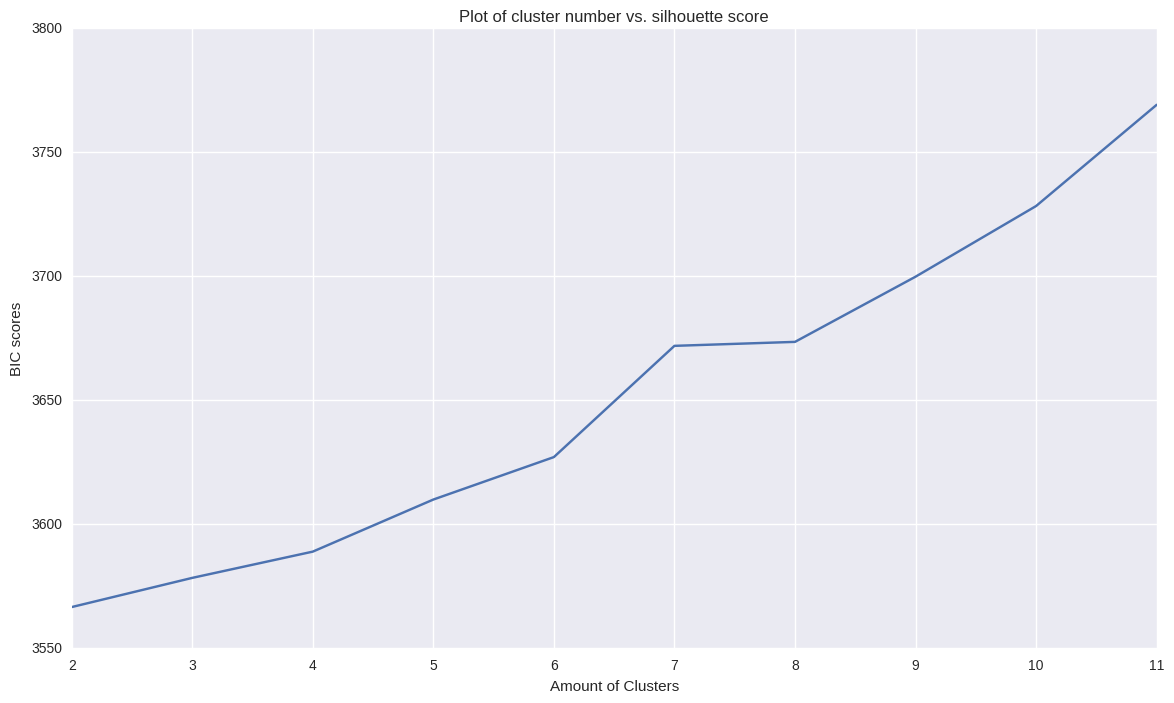

Optimum score: 3566.6389


In [22]:
def score_GMM_BIC(n_clusters):
    # Apply your clustering algorithm of choice to the reduced data 
    clusterer = GaussianMixture(n_components=n_clusters, random_state = RAN_STATE).fit(reduced_data)

    # Predict the cluster for each data point
    preds = clusterer.predict(reduced_data)
    
    # Find the cluster centers
    centers = clusterer.means_

    # Predict the cluster for each transformed sample data point
    sample_preds = clusterer.predict(pca_samples)

    # Calculate the mean silhouette coefficient for the number of clusters chosen
    score = clusterer.bic(reduced_data)
    return score
    
# Make an array of different silhouette_scores for clusters from 2 to 10.
GMM_scores = []
for i in range(2,12):   
    GMM_scores.append(score_GMM_BIC(i))

#Plot silhouette scores for a variety of cluster numbers.
plt.figure(figsize= FIG_SIZE)
plt.plot(range(2,12),GMM_scores)
plt.xlabel('Amount of Clusters')
plt.ylabel('BIC scores')
plt.title('Plot of cluster number vs. silhouette score')
plt.show()
print 'Optimum score: {:.4f}'.format(min(GMM_scores))

As the the model with the lowest BIC is preferred, the optimum score corresponding to 2 clusters. This agrees with our previous analysis using the silhouette score.

As can be seen in the above visualizations, the optimum amount of clusters for the dataset when reduced to 2 dimensions is 2. The silhouette score for 2 clusters is 0.3760 and the BIC is 3567. This means that there are two optimum customer segments that that whole sale distributer should be focusing on.


We can now assign some values to be used later for predictions and centers.

In [23]:
clusterer = GaussianMixture(n_components=2, random_state = RAN_STATE).fit(reduced_data)
preds = clusterer.predict(reduced_data)
centers = clusterer.means_
sample_preds = clusterer.predict(pca_samples)

## Cluster Visualization
We will now visualize the clusters that we have created:

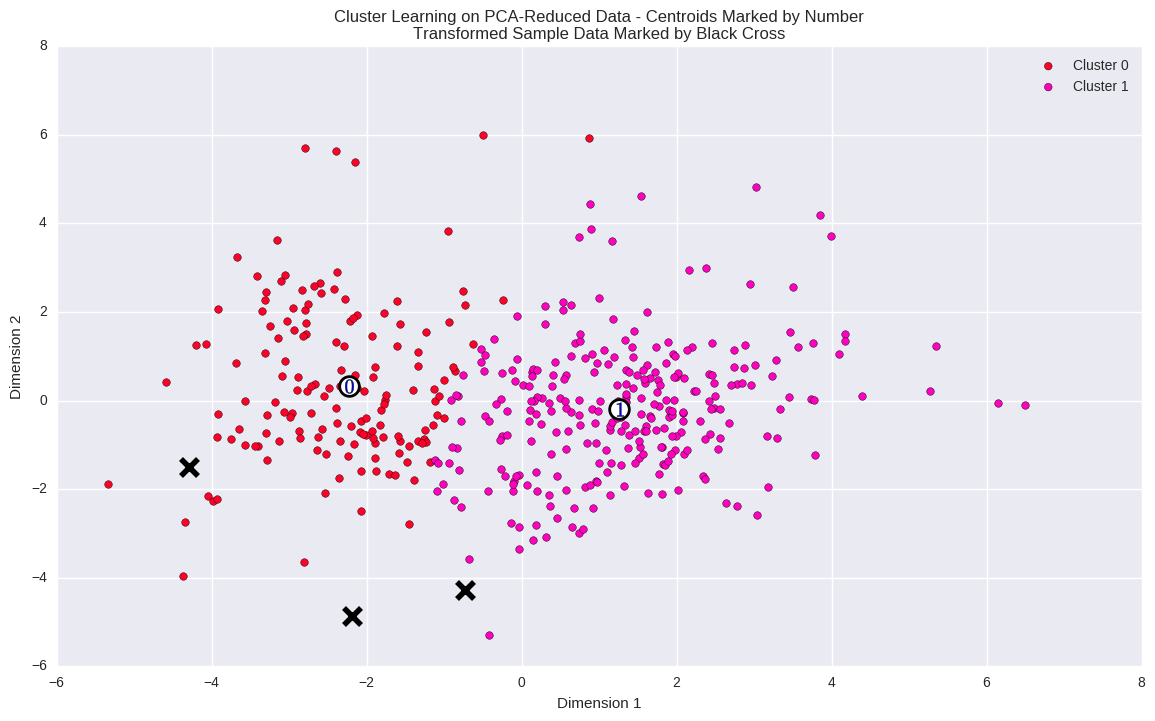

In [24]:
# Display the results of the clustering from implementation
rs.cluster_results(reduced_data, preds, centers, pca_samples)

### Implementation: Data Recovery
Each cluster present in the visualization above has a central point. These centers (or means) are not specifically data points from the data, but rather the *averages* of all the data points predicted in the respective clusters. For the problem of creating customer segments, a cluster's center point corresponds to *the average customer of that segment*. Since the data is currently reduced in dimension and scaled by a logarithm, we can recover the representative customer spending from these data points by applying the inverse transformations.

In [26]:
log_centers = pca.inverse_transform(centers)


true_centers = np.exp(log_centers)

# Display the true centers
segments = ['Segment {}'.format(i) for i in range(0,len(centers))]
true_centers = pd.DataFrame(np.round(true_centers), columns = data.keys())
true_centers.index = segments
display(true_centers)


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
Segment 0,3552.0,7837.0,12219.0,870.0,4696.0,962.0
Segment 1,8953.0,2114.0,2765.0,2075.0,353.0,732.0


## Analysis
Lets have a look at these two segments to try and decide what types of customers they represent.

In [27]:
med_values = np.around(data.median().values)

for i, cat in enumerate(data.columns):
    print "Median values for {}: ${:.2f}".format(cat, med_values[i])


display(data.describe())

print "Centers offset from median"
display(true_centers - np.around(data.median().values))

Median values for Fresh: $8504.00
Median values for Milk: $3627.00
Median values for Grocery: $4756.00
Median values for Frozen: $1526.00
Median values for Detergents_Paper: $816.00
Median values for Delicatessen: $966.00


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
count,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000
mean,12000.297727,5796.265909,7951.277273,3071.931818,2881.493182,1524.870455
std,12647.328865,7380.377175,9503.162829,4854.673333,4767.854448,2820.105937
min,3.000000,55.000000,3.000000,25.000000,3.000000,3.000000
25%,3127.750000,1533.000000,2153.000000,742.250000,256.750000,408.250000
50%,8504.000000,3627.000000,4755.500000,1526.000000,816.500000,965.500000
75%,16933.750000,7190.250000,10655.750000,3554.250000,3922.000000,1820.250000
max,112151.000000,73498.000000,92780.000000,60869.000000,40827.000000,47943.000000


Centers offset from median


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
Segment 0,-4952.0,4210.0,7463.0,-656.0,3880.0,-4.0
Segment 1,449.0,-1513.0,-1991.0,549.0,-463.0,-234.0


The data description is repeated above for quick reference. As the mean has the tendancy to be dragged upwards by large outliers (shown in the box plot above), the median has also been calculated along with the center offset to the median of the data of each of the major segments.

Datapoints in segment 0 are characterized by customers who purchase a lot of goods from the `Fresh` and `Frozen` categories. Conversely, customers in segment 1 purchase a lot of goods from the `Milk`, `Grocery` and `Detergent_Paper` catagories. Referencing the statistical description above, customers from segment 0, on average buy less than the mean of the data in all categories, but above the median for the `Fresh` and `Frozen`. Customers from segment 1 buy, on average less then the mean in all categories except for `Groceries`, `Milk` and `Detergents_Paper`, but above the median in each of these categories.

Since we decided to split the data into two classifications, my judgement is that segment 0 represents customers who sell food to consumers to prepare themselves (e.g. grocery stores, supermarkets, etc.), and segment 1 represents customers who prepare food or coffee to serve to consumers (coffee shops, etc.).


Now we can try to classify the sample points that we took out earlier

In [28]:
# Display the predictions
for i, pred in enumerate(sample_preds):
    print "Sample point", i, "predicted to be in Cluster", pred

Sample point 0 predicted to be in Cluster 0
Sample point 1 predicted to be in Cluster 1
Sample point 2 predicted to be in Cluster 0




* __Sample point 0 = Customer 181__: Our initial intuition from the beginning was that this customer was a small market or convenience store. Looking at the results of our customer segment analysis, it would seem that this would be in alignment with segment 0. When we see the predictions of our algorithm, we can see that our intuition matched our results.

* __Sample point 1 = Customer 325__: Our initial intuition was that this customer provides low-cost meals to needy people. This point would logically belong to segment 1. This is consistant with our prediction.

* __Sample point 2 = Customer 86__: Our initial intuition was that this point was a cafe. Referencing the customer segment analysis it would seem that this would be in alignment with segment 1. However, our predictions show that this customer is more aligned with segment 0.



# Conclusion

## A/B Test
Companies will often run [A/B tests](https://en.wikipedia.org/wiki/A/B_testing) when making small changes to their products or services to determine whether making that change will affect its customers positively or negatively. The wholesale distributor is considering changing its delivery service from currently 5 days a week to 3 days a week. However, the distributor will only make this change in delivery service for customers that react positively.

As the customers from segment 0 represent customers that sell food to consumers to prepare themselves (i.e supermarkets, retailers), and are most likely to keep a good stock of food on hand, they would be the most likely candidate to have delivery 3 days a week instead of 5. The customers from segment 1 represent cafes and restaurants, and are more likely to need a delivery in an emergency situation. Thus, the customers from segment 1 are more likely to need food delivered 5 days a week and should not be selected to have their delivery service changed.

In order to test this intuition, an A/B test could be performed as follows: a small sample from each customer segment could be selected for the delivery frequency change. The remaining members of each cluster would be the control group. Satisfaction surveys from each of the groups in each segment could be used to determine the effect of the delivery schedule change on each of the customer segments.

## Unsupervised learning to supervised learning

Using the result that we have generated in our clustering analysis, we can make a model that will classify new customers as part of "customer segment 1", or "customer segment 2". This would be done by using the existing estimated product spending categories as a features, and the generated customer segment as a labels, for training input to a supervised learning algorithm. The new customer's estimated product spending in each of the categories could then be fed into this trained algorithm to produce predictions on which customer segment the new customer would belong to.



## Visualizing Underlying Distributions

At the beginning of this project, it was discussed that the `'Channel'` and `'Region'` features would be excluded from the dataset so that the customer product categories were emphasized in the analysis. By reintroducing the `'Channel'` feature to the dataset, an interesting structure emerges when considering the same PCA dimensionality reduction applied earlier to the original dataset.

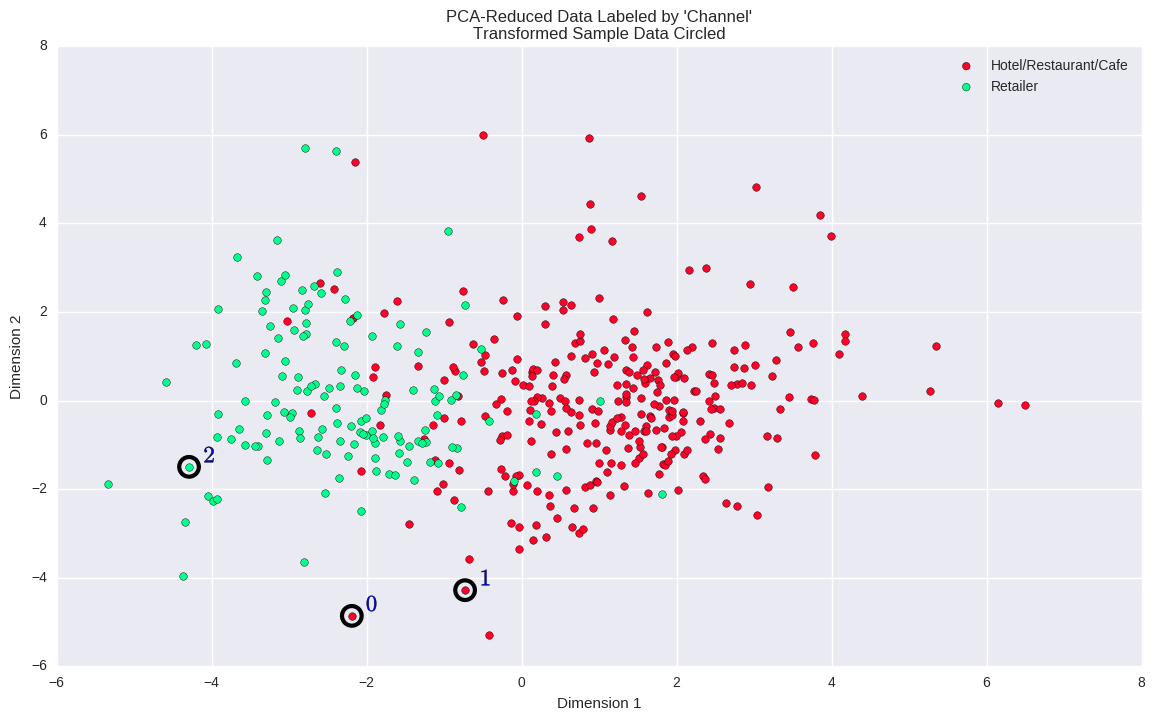

In [29]:
# Display the clustering results based on 'Channel' data
rs.channel_results(reduced_data, outliers, pca_samples)

Our clustering algorithm assumed that there were two customer categories being 'markets' and 'restaurantes' and 'cafes'. This is fairly consistent with the two different customer 'Channels' revealed by the underlying data. The majority of the points agree between our algorithm, and the hidden labels. However, there are a significant amount of points that are inconsistent. These points should perhaps not be classified as purely 'Retailers' or 'Hotels/Restaurants/Cafes' by our clustering algorithm but should instead be recognized as a mixture of the two as discussed in the Guassian Mixed model clustering section of this report. Ideally, the whole sale distributer should choose a threshold probability value for each of the datapoints pertainance to each segment (e.g. 80% segment 0 and 20% segment 1), before they decide to change the delivery frequency to the particular customer.